### RED PREDICCIÓN CONSUMO

In [2]:
# Cargamos el dataset
import pandas as pd
df = pd.read_csv("electrodatos.csv")

In [3]:
# Transformamos la fecha en datetime y calculamos el nombre del dia, hora y mes
df['datetime'] = pd.to_datetime(df['datetime'])
df['day_of_week'] = df['datetime'].dt.day_name()
df['Hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month_name()

# Seleccionamos las columnas de interés
df_consumo = df[['Consumo', 'day_of_week', 'Hour', 'month', 'Código universal de punto de suministro']]
df_consumo.head(5)

,Consumo,day_of_week,Hour,month,Código universal de punto de suministro
0,0.100,Tuesday,1,August,0
1,0.073,Tuesday,2,August,0
2,0.083,Tuesday,3,August,0
3,0.073,Tuesday,4,August,0
4,0.073,Tuesday,5,August,0


In [4]:
from sklearn.preprocessing import OrdinalEncoder

# Inicializamos las listas que van a contener los dataframe de 
# los individuos, seleccionados para train, test y validación.
train_list = []
val_list = []
test_list = []

# Definimos un econder para tranformar las variables categóricas 
# (dia de la semana y mes)
enc_ord = OrdinalEncoder()

# Tenemos en cuenta el dataframe de cada individuo por separado
# Se escogen 6 para train, 3 para validación y 2 para test
# Se elimina la columna del identificador despues de utilizarla
for i in range(11):
    if i < 6:
        tmp_df = df_consumo[df_consumo['Código universal de punto de suministro'] == i]
        tmp_df[['day_of_week', 'month']] = enc_ord.fit_transform(tmp_df[['day_of_week', 'month']])
        train_list.append(tmp_df)
        train_list[-1] = train_list[-1].drop('Código universal de punto de suministro', axis=1)

    elif i >= 6 and i < 9:
        tmp_df = df_consumo[df_consumo['Código universal de punto de suministro'] == i]
        tmp_df[['day_of_week', 'month']] = enc_ord.transform(tmp_df[['day_of_week', 'month']])
        val_list.append(tmp_df)
        val_list[-1] = val_list[-1].drop('Código universal de punto de suministro', axis=1)

    else:
        tmp_df = df_consumo[df_consumo['Código universal de punto de suministro'] == i]
        tmp_df[['day_of_week', 'month']] = enc_ord.transform(tmp_df[['day_of_week', 'month']])
        test_list.append(tmp_df)
        test_list[-1] = test_list[-1].drop('Código universal de punto de suministro', axis=1)

C:\Users\carloshermida\AppData\Local\Temp\ipykernel_6280\1652679423.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df[['day_of_week', 'month']] = enc_ord.fit_transform(tmp_df[['day_of_week', 'month']])
C:\Users\carloshermida\AppData\Local\Temp\ipykernel_6280\1652679423.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df[['day_of_week', 'month']] = enc_ord.fit_transform(tmp_df[['day_of_week', 'month']])
C:\Users\carloshermida\AppData\Local\Temp\ipykernel_6280\1652679423.py:19: SettingWithCo

In [5]:
# Se define la función de enventanado para que x sean 7x24 muestras y la salida y sean 1x24 datos
# De esta forma se consigue predecir el consumo un dia a partir de los 7 anteriores

import numpy as np

def sliding_window(data, labels, input_width, label_width=1, offset=1):
    x = []
    y = []

    for i in range(len(data)-input_width - offset - label_width):
        _x = data[i:i+input_width]
        _y = labels[i+input_width + offset : i + input_width + offset + label_width]
        x.append(_x)
        y.append(_y)

    x, y = np.array(x),np.array(y)

    if len(x.shape) == 2:
        x = x[:,:,np.newaxis]

    if len(y.shape) == 2:
        y = y[:,:,np.newaxis]

    return x, y 

In [6]:
input_width = 7 * 24
label_width = 1 * 24
offset = 0
target_labels = 'Consumo'

# Para cada conjunto, se calculan las ventanas para cada individuo y se concatenan.

# TRAIN
i = 0
x_train, y_train = sliding_window(train_list[i],train_list[i][target_labels], input_width, label_width=label_width, offset=offset)

for i in range(1, len(train_list)):
    x, y = sliding_window(train_list[i],train_list[i][target_labels], input_width, label_width=label_width, offset=offset)
    x_train = np.concatenate((x_train, x), axis=0)
    y_train = np.concatenate((y_train, y), axis=0)

# VAL
i = 0
x_val, y_val = sliding_window(val_list[i],val_list[i][target_labels], input_width, label_width=label_width, offset=offset)

for i in range(1, len(val_list)):
    x, y = sliding_window(val_list[i],val_list[i][target_labels], input_width, label_width=label_width, offset=offset)
    x_val = np.concatenate((x_val, x), axis=0)
    y_val = np.concatenate((y_val, y), axis=0)

# TEST
i = 0
x_test, y_test = sliding_window(test_list[i],test_list[i][target_labels], input_width, label_width=label_width, offset=offset)

for i in range(1, len(test_list)):
    x, y = sliding_window(test_list[i],test_list[i][target_labels], input_width, label_width=label_width, offset=offset)
    x_test = np.concatenate((x_test, x), axis=0)
    y_test = np.concatenate((y_test, y), axis=0)

In [7]:
# Definimos la estructura del modelo
import tensorflow as tf
gru_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(units=25, return_sequences=True), 
    tf.keras.layers.GRU(units=25, return_sequences=False), 
    tf.keras.layers.Dense(units=24), 
])

In [8]:
# Definimos los parámetros del modelo
MAX_EPOCHS = 10
batch_size = 32

def entrenar_modelo(model, train_data, train_label, val_data, val_label, epochs, batch_size, patience=5, verbose = 0):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(train_data, train_label, epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(val_data, val_label),
                        callbacks=[early_stopping], verbose=verbose)
    return history

In [17]:
# Entrenamos el modelo
history = entrenar_modelo(gru_model, x_train, y_train, x_val, y_val, MAX_EPOCHS, batch_size, verbose=1)

Epoch 1/10
2868/2868 [==============================] - 235s 81ms/step - loss: 0.1408 - mean_absolute_error: 0.2164 - val_loss: 0.0609 - val_mean_absolute_error: 0.1313
Epoch 2/10
2868/2868 [==============================] - 228s 80ms/step - loss: 0.1204 - mean_absolute_error: 0.1979 - val_loss: 0.0586 - val_mean_absolute_error: 0.1463
Epoch 3/10
2868/2868 [==============================] - 225s 79ms/step - loss: 0.1168 - mean_absolute_error: 0.1942 - val_loss: 0.0583 - val_mean_absolute_error: 0.1366
Epoch 4/10
2868/2868 [==============================] - 226s 79ms/step - loss: 0.1143 - mean_absolute_error: 0.1917 - val_loss: 0.0580 - val_mean_absolute_error: 0.1376
Epoch 5/10
2868/2868 [==============================] - 239s 83ms/step - loss: 0.1117 - mean_absolute_error: 0.1890 - val_loss: 0.0574 - val_mean_absolute_error: 0.1455
Epoch 6/10
2868/2868 [==============================] - 247s 86ms/step - loss: 0.1097 - mean_absolute_error: 0.1865 - val_loss: 0.0571 - val_mean_absolute_

In [18]:
# GUARDAR MODELO ENTRENADO
gru_model.save('gru_model_consumo.h5')

c:\Users\carloshermida\.venvs\hackudc24\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
# CARGAR MODELO ENTRENADO
gru_model = tf.keras.models.load_model('gru_model_consumo.h5')

1/1 [==============================] - 1s 813ms/step


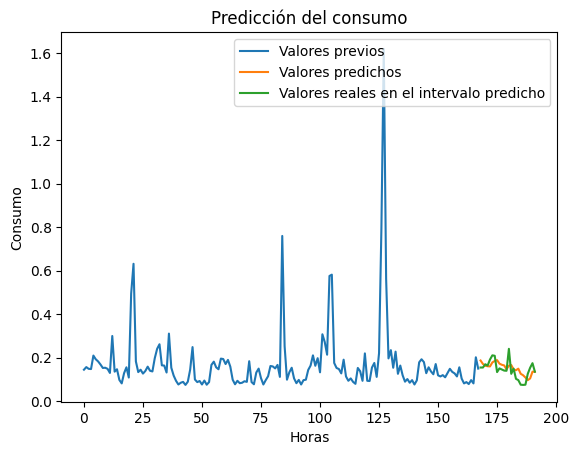

In [10]:
import matplotlib.pyplot as plt

# Elegimos un ejemplo para mostrar la predición gráficamente
# (le pasamos 7x24 (168) valores para predecir los 24 siguientes)
example = 6969

valores_reales = x_test[example,:,0]  
valores_predichos = gru_model.predict(x_test[example,:,:].reshape(1, 168, 4)).flatten()
valores_reales_test = y_test[example, :, 0]  

indices_tiempo = np.arange(len(valores_reales) + len(valores_predichos))
plt.plot(indices_tiempo[:len(valores_reales)], valores_reales, label='Valores previos',)
plt.plot(indices_tiempo[len(valores_reales):], valores_predichos, label='Valores predichos')
plt.plot(indices_tiempo[len(valores_reales):], valores_reales_test, label='Valores reales en el intervalo predicho')

plt.xlabel('Horas')
plt.ylabel('Consumo')
plt.legend()
plt.title('Predicción del consumo')

plt.show()

In [21]:
# Evaluamos el modelo con test
gru_model.evaluate(x_test, y_test)

1044/1044 [==============================] - 22s 20ms/step - loss: 0.1038 - mean_absolute_error: 0.1697


[0.10379055887460709, 0.16970860958099365]

#### INTRODUCIR NUEVOS DATOS

In [77]:
# INTRODUCIR NUEVOS DATOS (EL USUARIO NOS PASA 168 DATOS)
# Por simplicidad suponemos que el usuario es el número 10 y nos da los valores de la última semana registrada
df = pd.read_csv("electrodatos.csv")
df_usuario = df[df['Código universal de punto de suministro'] == 10]
df_usuario = df_usuario[len(df_usuario)-(7*24):]
df_usuario

,Código universal de punto de suministro,Fecha,Hora,Consumo,Método de obtención,datetime
145775,10,2023-08-01,1,0.112,Real,2023-08-01 01:00:00
145776,10,2023-08-01,2,0.110,Real,2023-08-01 02:00:00
145777,10,2023-08-01,3,0.100,Real,2023-08-01 03:00:00
145778,10,2023-08-01,4,0.072,Real,2023-08-01 04:00:00
145779,10,2023-08-01,5,0.105,Real,2023-08-01 05:00:00
...,...,...,...,...,...,...
145938,10,2023-08-07,20,0.105,Real,2023-08-07 20:00:00
145939,10,2023-08-07,21,0.104,Real,2023-08-07 21:00:00
145940,10,2023-08-07,22,1.122,Real,2023-08-07 22:00:00
145941,10,2023-08-07,23,0.196,Real,2023-08-07 23:00:00


1/1 [==============================] - 0s 44ms/step


C:\Users\carloshermida\AppData\Local\Temp\ipykernel_6280\787404498.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usuario[['day_of_week', 'month']] = enc_ord.transform(df_usuario[['day_of_week', 'month']])


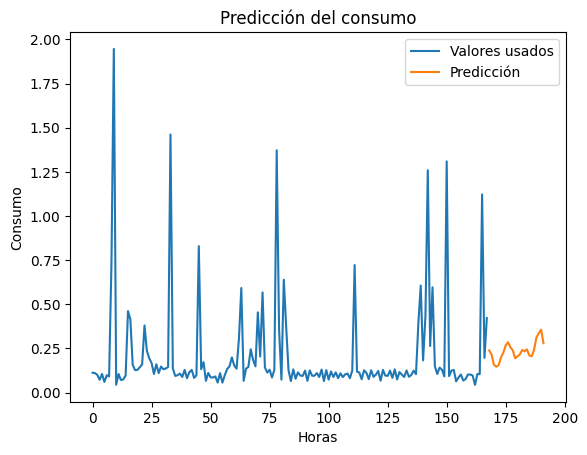

[0.23814008 0.21598107 0.15730809 0.1463086  0.1544739  0.19902568
 0.2259587  0.2676208  0.28435934 0.25646645 0.23883218 0.19392467
 0.20498611 0.21622355 0.24054417 0.23377708 0.24448186 0.20975442
 0.20560601 0.2403299  0.31135586 0.3354689  0.35572964 0.2792554 ]


In [78]:
#### EJECUTAR PARA PREDECIR

# PREPROCESADO
df_usuario['datetime'] = pd.to_datetime(df_usuario['datetime'])
df_usuario['day_of_week'] = df_usuario['datetime'].dt.day_name()
df_usuario['Hour'] = df_usuario['datetime'].dt.hour
df_usuario['month'] = df_usuario['datetime'].dt.month_name()
df_usuario = df_usuario[['Consumo', 'day_of_week', 'Hour', 'month', 'Código universal de punto de suministro']]

# NORMALIZACIÓN
df_usuario[['day_of_week', 'month']] = enc_ord.transform(df_usuario[['day_of_week', 'month']])
df_usuario = df_usuario.drop('Código universal de punto de suministro', axis=1)

# PREDICCIÓN
prediccion = gru_model.predict(df_usuario.to_numpy().reshape(1, 168, 4)).flatten()
valores_usados = df_usuario["Consumo"]
indices_tiempo = np.arange(len(valores_usados) + len(prediccion))
plt.plot(indices_tiempo[:len(valores_usados)], valores_usados, label='Valores usados',)
plt.plot(indices_tiempo[len(valores_usados):], prediccion, label='Predicción')
plt.xlabel('Horas')
plt.ylabel('Consumo')
plt.legend()
plt.title('Predicción del consumo')
plt.show()
print(prediccion)